In [1]:
import sys
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from torch.autograd import Function
from torch.optim import Adam
from graphviz import Source
from pyeda.boolalg.bdd import bdd2expr

filepath = os.path.abspath('')
sys.path.append(os.path.join(filepath, "..", "..", "compiling_nn"))
from build_odd import compile_nn

In [2]:
class StepFunction(Function):
    @staticmethod
    def forward(ctx, input):
        output = torch.where(input>=0, torch.tensor(1.0), torch.tensor(0.0))
        ctx.save_for_backward(input)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = torch.zeros_like(input)
        return grad_input
    
class StepActivation(nn.Module):
    def forward(self, input):
        return StepFunction.apply(input)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(25,5)
        self.a1 = {True: nn.Sigmoid(), False: StepActivation()}
        self.l2 = nn.Linear(5,1)
        self.a2 = {True: nn.Sigmoid(), False: StepActivation()}
    
    def forward(self, x):
        x = self.l1(x)
        x = self.a1[self.training](x)
        x = self.l2(x)
        x = self.a2[self.training](x)
        return x

In [3]:
# df = pd.read_csv("loan_data_set.csv", sep=",")

# func = {"Gender" :              lambda x : x=="Male",
#         "Married":              lambda x : x=="Yes",
#         # "Dependents":           lambda x : x!="0",          # hot encoding
#         "Education":            lambda x : x=="Graduate",
#         "Self_Employed":        lambda x : x=="Yes",
#         # "ApplicantIncome":      lambda x : x > 3000,        #
#         # "CoapplicantIncome":    lambda x : x > 0,           #
#         # "LoanAmount":           lambda x : x >= 100,        #
#         # "Loan_Amount_Term":     lambda x : x >= 360,        #
#         "Credit_History":       lambda x : bool(x),
#         # "Property_Area":        lambda x : x=="Rural",      # hot encoding
#         "Loan_Status":          lambda x : x=="Y"}

# for c in df.columns:
#     df[c] = df[c].apply(func.get(c, lambda x : x))

# df_x = df[["Gender", "Married", "Dependents", "Education", "Self_Employed", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History", "Property_Area"]]
# df_y = df[["Loan_Status"]]

# x = torch.Tensor(df_x.to_numpy(dtype=int))
# y = torch.Tensor(df_y.to_numpy(dtype=int))

# print(x.shape, y.shape)

In [4]:
df = pd.read_csv("loan_data_set.csv", sep=",")
df = df.drop(columns=["Loan_ID"])

df_y = pd.get_dummies(df[["Loan_Status"]], drop_first=True)
df_x = df.drop(columns=["Loan_Status"])

nunique = df_x.nunique(axis=0)
df_x_mean = df_x.mean(axis=0, numeric_only=True)

for col, n in nunique.items():
    if n > 4:
        df_x[col] = df_x[col].apply(lambda x : min(4, x//(.5*df_x_mean[col])))

df_x = pd.get_dummies(df_x, columns=df_x.columns, drop_first=True)

x = torch.Tensor(df_x.to_numpy(dtype=int))
y = torch.Tensor(df_y.to_numpy(dtype=int))

print(x.shape, y.shape)

torch.Size([614, 25]) torch.Size([614, 1])


In [5]:
net = Net()

max_epoch = 1000
learning_rate = 1e-2

loss_fn = nn.BCELoss()
optimizer = Adam(net.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    net.train()
    y_pred = net(x)
    loss = loss_fn(y_pred, y)

    net.zero_grad()
    loss.backward()
    optimizer.step()

    net.eval()
    y_pred = net(x)
    loss_step = loss_fn(y_pred, y)
    if (epoch+1)%50==0:
        print(loss, loss_step)

tensor(0.6052, grad_fn=<BinaryCrossEntropyBackward0>) tensor(30.4560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5603, grad_fn=<BinaryCrossEntropyBackward0>) tensor(29.3160, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5160, grad_fn=<BinaryCrossEntropyBackward0>) tensor(24.7557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4972, grad_fn=<BinaryCrossEntropyBackward0>) tensor(22.9642, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4763, grad_fn=<BinaryCrossEntropyBackward0>) tensor(21.6612, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4524, grad_fn=<BinaryCrossEntropyBackward0>) tensor(20.8469, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4275, grad_fn=<BinaryCrossEntropyBackward0>) tensor(20.6840, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4028, grad_fn=<BinaryCrossEntropyBackward0>) tensor(19.7068, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3822, grad_fn=<BinaryCrossEntropyBackward0>) tensor(21.3355, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3656, grad

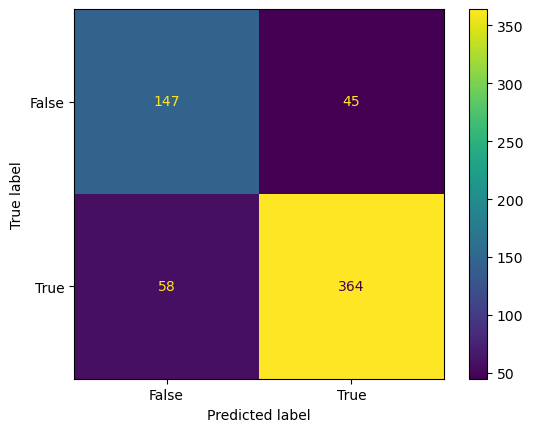

In [6]:
net.eval()
confusion_matrix = metrics.confusion_matrix(y, net(x).detach().numpy())

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

In [7]:
# bdd, bdd_vars = compile_nn(net)
# # display(Source(bdd.to_dot()))

### example1.pth

D'après le BDD, on peut dire que le prêt est refusé si:
 - $\neg$ Credit History,
 - Self-Employed
 - $\neg$ Education
 - $\neg$ Married
 - Si c'est une femme, Dependants

In [8]:
torch.save(net.state_dict(), "example.pth")

# Balance class

In [9]:
itrue = df_y.index[df_y["Loan_Status_Y"]==1].tolist()
ifalse = df_y.index[df_y["Loan_Status_Y"]==0].tolist()

swap = len(itrue) > len(ifalse)
if swap:
    itrue,ifalse=ifalse,itrue

ifalse = random.choices(ifalse, k=len(itrue))

if swap:
    itrue,ifalse=ifalse,itrue

print(df_y.iloc[itrue+ifalse].value_counts())

x_r=torch.Tensor(df_x.iloc[itrue+ifalse].to_numpy(dtype=int))
y_r=torch.Tensor(df_y.iloc[itrue+ifalse].to_numpy(dtype=int))

print(x_r.shape,y_r.shape)

Loan_Status_Y
0                192
1                192
dtype: int64
torch.Size([384, 25]) torch.Size([384, 1])


In [10]:
net = Net()

max_epoch = 1000
learning_rate = 1e-2

loss_fn = nn.BCELoss()
optimizer = Adam(net.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    net.train()
    y_pred = net(x_r)
    loss = loss_fn(y_pred, y_r)

    net.zero_grad()
    loss.backward()
    optimizer.step()

    net.eval()
    y_pred = net(x_r)
    loss_step = loss_fn(y_pred, y_r)
    if (epoch+1)%50==0:
        print(loss, loss_step)

tensor(0.6293, grad_fn=<BinaryCrossEntropyBackward0>) tensor(34.8958, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5756, grad_fn=<BinaryCrossEntropyBackward0>) tensor(32.2917, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5355, grad_fn=<BinaryCrossEntropyBackward0>) tensor(27.0833, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4919, grad_fn=<BinaryCrossEntropyBackward0>) tensor(25.7812, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4466, grad_fn=<BinaryCrossEntropyBackward0>) tensor(21.3542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4000, grad_fn=<BinaryCrossEntropyBackward0>) tensor(20.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3617, grad_fn=<BinaryCrossEntropyBackward0>) tensor(20.8333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3297, grad_fn=<BinaryCrossEntropyBackward0>) tensor(16.9271, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3047, grad_fn=<BinaryCrossEntropyBackward0>) tensor(16.1458, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2850, grad

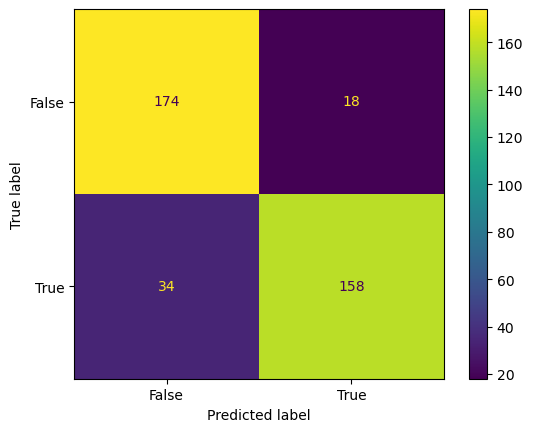

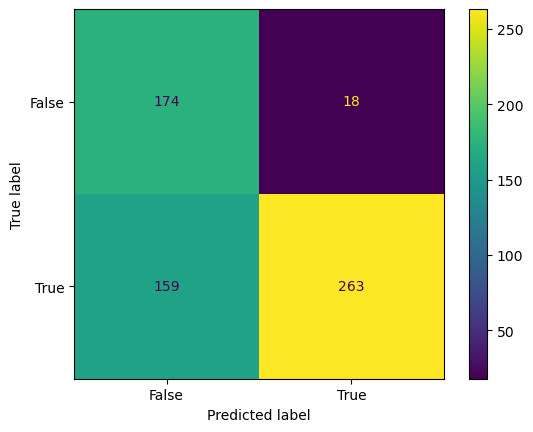

In [13]:
net.eval()
confusion_matrix = metrics.confusion_matrix(y_r, net(x_r).detach().numpy())

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

confusion_matrix = metrics.confusion_matrix(y, net(x).detach().numpy())

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

In [12]:
# bdd, bdd_vars = compile_nn(net)
# # display(Source(bdd.to_dot()))

finir encadrer ce dataset
voir autre dataset Lending club loan
binarisation des réseaux de neuronnes
random forest encoding

****
apprendre réseau a partir d'un autre ?? (sans les données) -> meta learning ?

====
intranet ticket machine crédit BxINP
